In [1]:
import os
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from scipy.signal import butter
from scipy.signal import lfilter
from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
from tueplots import bundles
import numpy as np

plt.rcParams.update(bundles.tmlr2023())
plt.rcParams['axes.labelsize']=12
plt.rcParams['axes.titlesize']=12
plt.rcParams['legend.fontsize']=8

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

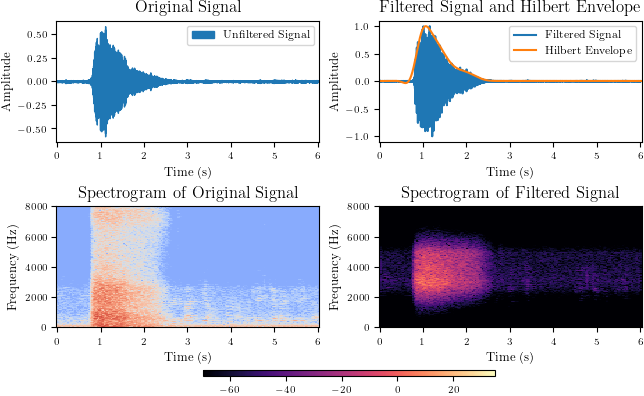

In [7]:
remove = ['P65']
directory = '../data/N95/'    # Path to the folder containing the audio files
sr=16000
cutoff_low = 3000        # desired cutoff frequency of the filter, Hz
cutoff_high = 5000       # desired cutoff frequency of the filter, Hz
order = 5               # desired order of the filter

nyq_rate = sr /0.5      # Nyquist rate is twice the sampling rate.
width = 1.0/nyq_rate    # 5 Hz filter transition width.
ripple_db = 10.0        # stop band attenuation
fL_hz = 10              #

# pdf_name = "New_samples_1.pdf"          # Name of the pdf file to save the plots

count= 0
# Looping through all the files in the directory
for filename in os.listdir(directory):
    # print(filename.split('.')[0])
    if filename.split('.')[0] in remove:
        # Path to the file
        f = os.path.join(directory, filename)
        count+=1
        # checking if it is a file
        if os.path.isfile(f):
            
            # Load Audio File
            x , sr = librosa.load(f,sr=16000)

            # Band pass filtering
            x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,sr,order)
            
            # Hilbert Transform
            x_filt_hilbert = signal.hilbert(x_filt)
            envelope_hat = np.abs(x_filt_hilbert)
            
            #filter the Hilbert envelope
            N, beta = signal.kaiserord(ripple_db, width)
            taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
            envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
            t = np.arange(0,len(envelope_hat_filt))/sr

            stft_spectrogram=librosa.amplitude_to_db(np.abs(librosa.stft(x)))
            stft_spectrogram_filt=librosa.amplitude_to_db(np.abs(librosa.stft(x_filt)))

            minmin = min(stft_spectrogram.min(),stft_spectrogram_filt.min())
            maxmax = max(stft_spectrogram.max(),stft_spectrogram_filt.max())


            
            # Plotting the Original Signal
            fig = plt.figure()
            ax1 = plt.subplot(221)
            img1 = librosa.display.waveshow(x, sr=sr,ax=ax1,label='Unfiltered Signal')
            ax1.set_ylabel('Amplitude')
            ax1.set_title('Original Signal')
            ax1.set_xlabel('Time (s)')
            ax1.legend(loc="upper right")

            # Plotting the Spectrogram of the Original Signal
            ax2 = plt.subplot(223,sharex=ax1)
            img2 = librosa.display.specshow(stft_spectrogram, sr=sr, x_axis='time',y_axis='hz',ax=ax2, vmin=minmin, vmax=maxmax)
            ax2.set_ylabel('Frequency (Hz)')
            ax2.set_title('Spectrogram of Original Signal')
            ax2.set_xlabel('Time (s)')

            # Plotting the Filtered Signal and Hilbert Envelope
            ax3 = plt.subplot(222)
            ax3.plot(t,x_filt/max(x_filt),label='Filtered Signal')
            ax3.plot(t,envelope_hat_filt/max(envelope_hat_filt),label='Hilbert Envelope')
            ax3.set_ylabel('Amplitude')
            ax3.set_xlabel('Time (s)')
            ax3.set_title('Filtered Signal and Hilbert Envelope')
            ax3.legend(loc="upper right")

            # Plotting the Spectrogram of the Filtered Signal
            ax4 = plt.subplot(224,sharex=ax3)
            img4 = librosa.display.specshow(stft_spectrogram_filt, sr=sr, x_axis='time',y_axis='hz',ax=ax4, vmin=minmin, vmax=maxmax)
            ax4.set_ylabel('Frequency (Hz)')
            ax4.set_xlabel('Time (s)')
            ax4.set_title('Spectrogram of Filtered Signal')
            plt.colorbar(img4,ax=[ax2,ax4],orientation='horizontal',shrink=0.5,aspect=50)

            # plt.suptitle("Original Signal and Filtered Signal")

            plt.savefig("../figures/filter_signal.pdf")
            plt.show()
# pdf.close()      